In [1]:
#%matplotlib notebook
#%config IPython.matplotlib.backend = 'retina'

In [1]:
import numpy as np
import pandas as pd
from matplotlib import rcParams
import matplotlib.pyplot as plt
import datetime
#rcParams['savefig.dpi'] = 300
#rcParams['figure.dpi'] = 300

## Read in data from file

This will read in the data from 29/01/1992 - 31/03/1992 and plot it before moving onto set up the celerite kernels

In [8]:
y = 1993
e = 1
model_type = 'gamma_beta_2'
#output_path = '/mnt/storage/003. Data/015. BiSON/SMMF/Sutherland/filtered_FFTs/ranked_peaks_%s/'%(self.model_type)
root_directory = '/mnt/storage/003. Data/015. BiSON/SMMF/Sutherland/filtered_FFTs/ranked_peaks_%s/'%(model_type)
df_SMMF = pd.read_csv(root_directory + '%s/TS_%s_%s.csv'%(y, y, e), index_col=[0])
df_SMMF.set_index([[datetime.datetime.strptime(t, "%Y-%m-%d %H:%M:%S") for t in df_SMMF.index.values]], inplace=True)
"""
# set errors to be some arbitrary, small amount (this needs to be set to something physical)
#df_SMMF['yerr'] = np.random.normal(0, 0.01)
"""
# Set error based on BiSON v_res error (from Steve summer 2018)
import scipy.constants as sc
K = (8/3)*(sc.physical_constants['Bohr magneton'][0]/sc.h)*(769.9E-9)/10000 #approx 2.89m/s/G at wavelength approx 7699 Angstr.
df_SMMF['yerr'] = 0.5 * 0.231 / K
df_SMMF['yerr'] *= 1

print(df_SMMF.head())

                     raw  subtract_1  subtract_2  subtract_3  subtract_4  \
1993-01-01 00:00:00  NaN         NaN         NaN         NaN         NaN   
1993-01-01 00:00:40  NaN         NaN         NaN         NaN         NaN   
1993-01-01 00:01:20  NaN         NaN         NaN         NaN         NaN   
1993-01-01 00:02:00  NaN         NaN         NaN         NaN         NaN   
1993-01-01 00:02:40  NaN         NaN         NaN         NaN         NaN   

                     subtract_5  subtract_6  subtract_7  subtract_8  \
1993-01-01 00:00:00         NaN         NaN         NaN         NaN   
1993-01-01 00:00:40         NaN         NaN         NaN         NaN   
1993-01-01 00:01:20         NaN         NaN         NaN         NaN   
1993-01-01 00:02:00         NaN         NaN         NaN         NaN   
1993-01-01 00:02:40         NaN         NaN         NaN         NaN   

                     subtract_9  subtract_10      yerr  
1993-01-01 00:00:00         NaN          0.0  0.040195  
19

Plot the data

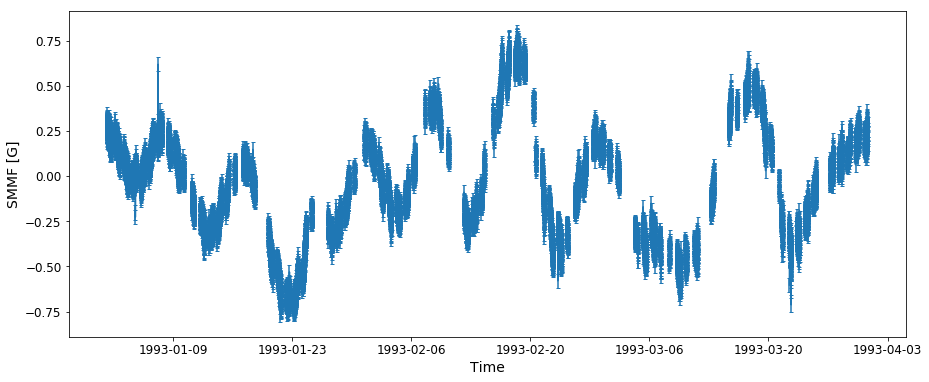

In [9]:
# Plot
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('SMMF [G]', fontsize=14)
ax.tick_params(labelsize=12)
ax.errorbar(df_SMMF.index.values, df_SMMF['raw'], yerr=df_SMMF['yerr'], capsize=2)
plt.show()

Now we need to convert the signal from PSD into amplitude ($A(f(k))$): $A(f(k)) \, = \, \sqrt{2 \,\mathrm{PSD}}$

BUT - first need to go from PSD in units [G$^2$$\mu$Hz$^{-1}$] into [G$^2$]

Then to convert from amplitude to the frequency domain signal ($Z(f(k))$): $Z(f(k)) \, = \, A(f(k)) \, e^{i \phi(f(k)))}$, where $\phi(f(k))$ is some random phase supplied to the signal between $0$ and $2\pi$.

Begin FFT...
Pre-mask times length: 194400
Post-mask times length: 58487


/home/exr007/.local/lib/python3.5/site-packages/astropy/stats/lombscargle/implementations/fast_impl.py:93: RuntimeWarning: invalid value encountered in true_divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))


TS_var: 0.09471985036464228
FD: 0.09471985036464227


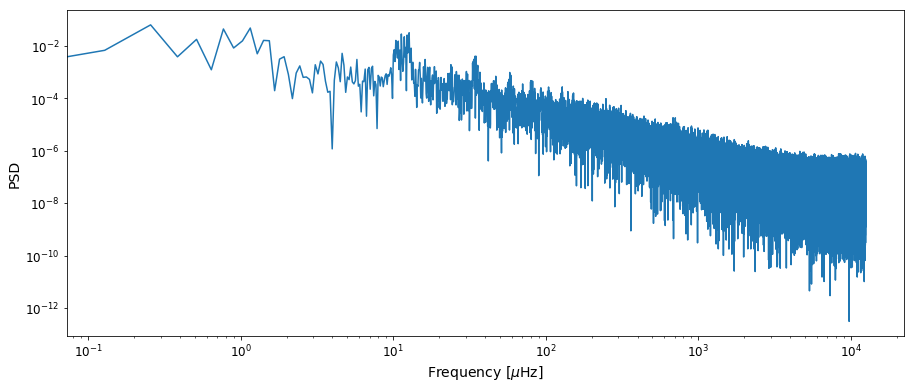

Peak at nu_0 = 0.257201646090535 muHz


In [4]:
import timeseries_FFT

def FFT(start, end, data = None, oversample = False, plot=False):
    print('Begin FFT...')
    # data = self.Vn_df[0] # set FFT data
    data = data
    error = data*0.0001

    f = timeseries_FFT.timeseries_FFT_plot(data, error, start, end, 'SMMF [G]', 'PSD [$G^2$$\mu$Hz$^{-1}$]', maj_tick = .5, min_tick=.05)
    freqs, power, times = f.FT_data(type='nans')
    if plot == True:
        f.make_plot()
    return freqs, power, times

# Re-compute the power spectrum
freqs, power, times = FFT(start = pd.to_datetime(df_SMMF.index.values[0]), end = pd.to_datetime(df_SMMF.index.values[-1]), data = df_SMMF['raw'], plot=False, oversample=False)

# Plot power re-calculated power spectrum
fig, ax = plt.subplots(figsize=(15,6))
ax.set_xlabel('Frequency [$\mu$Hz]', fontsize=14)
ax.set_ylabel('PSD', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(freqs, power)
plt.show()

print("Peak at nu_0 = %s muHz"%freqs[np.argmax(power)])

                         SMMF       err        t
1993-01-01 04:31:20  0.266715  0.040195  16280.0
1993-01-01 04:32:00  0.224210  0.040195  16320.0
1993-01-01 04:32:40  0.221022  0.040195  16360.0
1993-01-01 04:33:20  0.284777  0.040195  16400.0
1993-01-01 04:34:00  0.231647  0.040195  16440.0


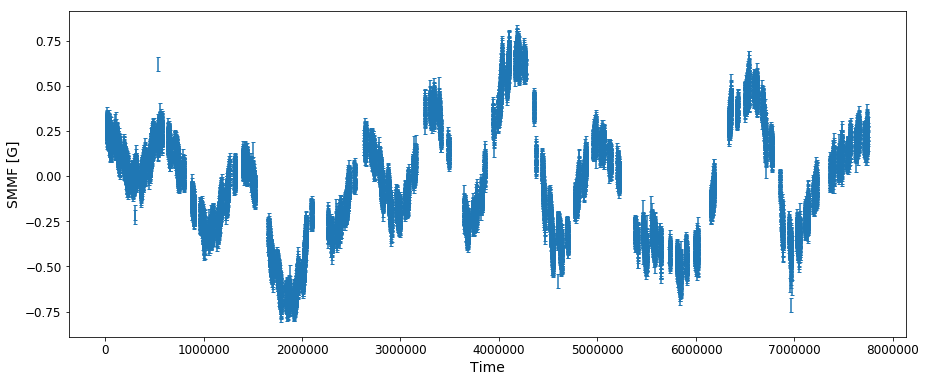

In [8]:
# times in seconds
good_SMMF = pd.DataFrame({'t':times, 'SMMF':df_SMMF['raw'][np.isfinite(df_SMMF['raw'])], 'err':df_SMMF['yerr'][np.isfinite(df_SMMF['raw'])]})
print(good_SMMF.head())

# Plot with time axis as seconds
fig, ax = plt.subplots(figsize=(15, 6))
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('SMMF [G]', fontsize=14)
ax.tick_params(labelsize=12)
ax.errorbar(good_SMMF['t'], good_SMMF['SMMF'], yerr=good_SMMF['err'], capsize=2, ls='', )
#ax.set_xlim([100000.0, 150000.0])
plt.show()

## Celerite model

Now we will try to model the time-series using a GP.

Note that we assume Q-factor: $Q \, = \, \frac{\nu_0}{\Gamma}$

In [9]:
import celerite
from celerite import terms
from celerite.modeling import Model

"""# Define the custom kernel
class RotationTerm(terms.Term):
    parameter_names = ("log_amp", "log_timescale", "log_period", "log_factor")

    def get_real_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) * (1.0 + f) / (2.0 + f),
            np.exp(-log_timescale),
        )

    def get_complex_coefficients(self, params):
        log_amp, log_timescale, log_period, log_factor = params
        f = np.exp(log_factor)
        return (
            np.exp(log_amp) / (2.0 + f),
            0.0,
            np.exp(-log_timescale),
            2*np.pi*np.exp(-log_period),
        )"""

"""# Define the custom kernel (f=-1)
class RotationTerm(terms.Term):
    parameter_names = ("log_amp", "log_timescale", "log_period")

    def get_real_coefficients(self, params):
        log_amp, log_timescale, log_period = params
        f = -1
        return (
            np.exp(log_amp) * (1.0 + f) / (2.0 + f),
            np.exp(-log_timescale),
        )

    def get_complex_coefficients(self, params):
        log_amp, log_timescale, log_period = params
        f = -1
        return (
            np.exp(log_amp) / (2.0 + f),
            0.0,
            np.exp(-log_timescale),
            2*np.pi*np.exp(-log_period),
        )"""


# Jitter Term
bounds = dict(log_sigma=(-20, 5))
kernel = terms.JitterTerm(log_sigma=-5, bounds=bounds)

"""# A QUASI-periodic component for fundamental period
bounds=dict(log_amp=(-15.0, 0.0), log_timescale=(12, 17.0), log_period=(14, 15.25), log_factor=(-5.0, 5.0))
amp = np.var(df_SMMF['raw']) #amplitude
L = 40*3600*24 #timescale
P = 27*3600*24 #period
f = 1.0 #factor
print(np.log(amp), np.log(L), np.log(P), np.log(f))
#kernel += terms.TermSum(RotationTerm(log_amp=np.log(amp), log_timescale=np.log(L), log_period=np.log(P), log_factor=np.log(f),
#    bounds=bounds),)
kernel += terms.TermSum(RotationTerm(log_amp=np.log(amp), log_timescale=np.log(L), log_period=np.log(P),
    bounds=bounds),)
    
    """


# A periodic component for fundamental harmonic peak
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-10, 20), log_Q=(-10, 10), log_omega0=(-13.25, -12.5))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / (27.0*3600*24))
#S0 = np.var(df.SMMF.values) / (w0 * Q) / 10
S0 = np.var(good_SMMF['SMMF']) / (w0 * Q) / 1.0
print(np.log(S0), np.log(Q), np.log(w0))
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)


# A 2nd periodic component for 2nd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-10, 20), log_Q=(-10, 10), log_omega0=(-12.5, -11.9))
Q = 1
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / (13.5*3600*24))
S0 = np.var(good_SMMF['SMMF']) / (w0 * Q) / 1.0
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# A 3rd periodic component for 3rd harmonic
#bounds = dict(log_S0=(-10, 30), log_Q=(-20, 20), log_omega0=(-20, 15))
bounds = dict(log_S0=(-10, 20), log_Q=(-10, 5), log_omega0=(-12.0, -11.5))
Q = 10
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (1.0 / (9*3600*24))
S0 = np.var(good_SMMF['SMMF']) / (w0 * Q) / 3
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# An SHO component for background
bounds = dict(log_S0=(-5, 20), log_Q=(-20, -1), log_omega0=(-20, -13.5))
Q = 0.1
#w0 = (1.0 / 27.0 / 2.0 / np.pi)
w0 = 2.0 * np.pi * (0.001/(24*3600))
S0 = np.var(good_SMMF['SMMF']) / (w0 * Q) / 100
print(np.log(S0))
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

# Create and compute GP
gp = celerite.GP(kernel, mean=np.mean(good_SMMF.SMMF.values), fit_mean=False)
gp.compute(good_SMMF.t, good_SMMF.err)  # Always need to call compute once
print("Initial log likelihood: %.6f"%(gp.log_likelihood(good_SMMF['SMMF'].values)))
print(gp.get_parameter_vector())

8.165285973780216 2.302585092994046 -12.82470275438713
11.777204386758026
Initial log likelihood: 115025.944941
[ -5.           8.16528597   2.30258509 -12.82470275   9.77472389
   0.         -12.13155557   5.9680614    2.30258509 -11.72609047
  11.77720439  -2.30258509 -16.43662117]


Create likelihood function for emcee to work with

In [10]:
def log_probability(params):
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    if not np.isfinite(lp):
        return -np.inf
    #if params[0] < 0:
    #    return -np.inf
    return gp.log_likelihood(good_SMMF['SMMF'].values) + lp

Run emcee on this

In [11]:
import emcee

initial = gp.get_parameter_vector()
print(initial)
print(log_probability(initial))

ndim, nwalkers = len(initial), 50
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, a=2)

import time
start_time = time.time()

print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 10000)
print("... elapsed_time = %.6f s"%(time.time() - start_time))

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 10000);

print("We're done here...")
print("... elapsed_time = %.6f s"%(time.time() - start_time))

print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

print(gp.get_parameter_vector())

[ -5.           8.16528597   2.30258509 -12.82470275   9.77472389
   0.         -12.13155557   5.9680614    2.30258509 -11.72609047
  11.77720439  -2.30258509 -16.43662117]
115025.94494103122
Running burn-in...
... elapsed_time = 4955.225036 s
Running production...
We're done here...
... elapsed_time = 9829.414498 s
Mean acceptance fraction: 0.160
[ -4.26823549   3.04547322   3.12066406 -13.59173286  12.87216502
  -2.06065389 -11.79031338 -12.58372438  -9.81456553 -12.0826512
 -10.2118587   -8.01544301 -13.79633743]


(500000, 13)


Text(0.5,0,'Step Number')

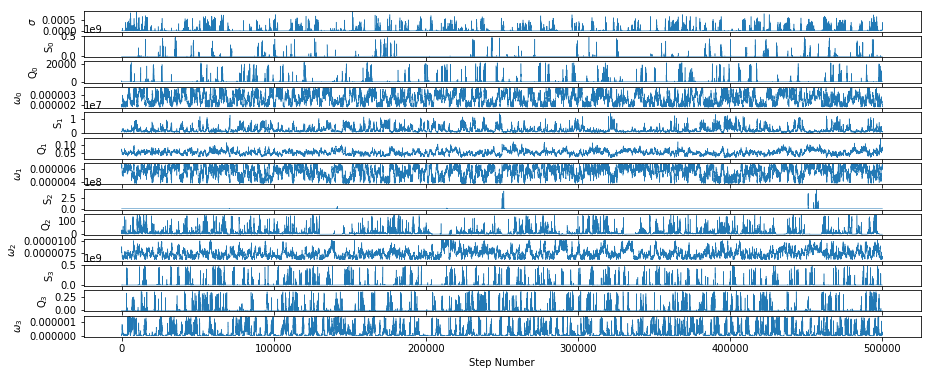

In [12]:
nparams = len(initial)
sam = sampler.flatchain
exp_sam = np.exp(sam)
print(np.shape(sam))
#lbls = ["$\\sigma$", "$A$", "$L$", "$P$", "$S_0$", "$Q$", "$\\omega_0$"]
lbls = ["$\\sigma$", "S$_0$", "Q$_0$", "$\\omega_0$", "S$_1$", "Q$_1$", "$\\omega_1$", "S$_2$", "Q$_2$", "$\\omega_2$", "S$_3$", "Q$_3$", "$\\omega_3$"]
fig, ax = plt.subplots(nparams, figsize=(15,6))
for i in range(nparams):
    ax[i].plot(exp_sam[:, i], lw=0.5, alpha=0.99)
    ax[i].set_ylabel(lbls[i])
    
ax[-1].set_xlabel('Step Number')

Import and plot corner.

$\sigma$ units: TBC

$S_0$ units: TBC

$Q_0$ units: unitless

$\omega$ units: rad/day

$\sigma$= 1.71590e-06 (+1.05436e-04 / -1.69825e-06)
S$_0$= 1.45442e+01 (+3.34226e+04 / -1.45355e+01)
Q$_0$= 7.88595e-01 (+5.89911e+02 / -7.88010e-01)
$\omega_0$= 2.58261e-06 (+7.17065e-07 / -6.26578e-07)


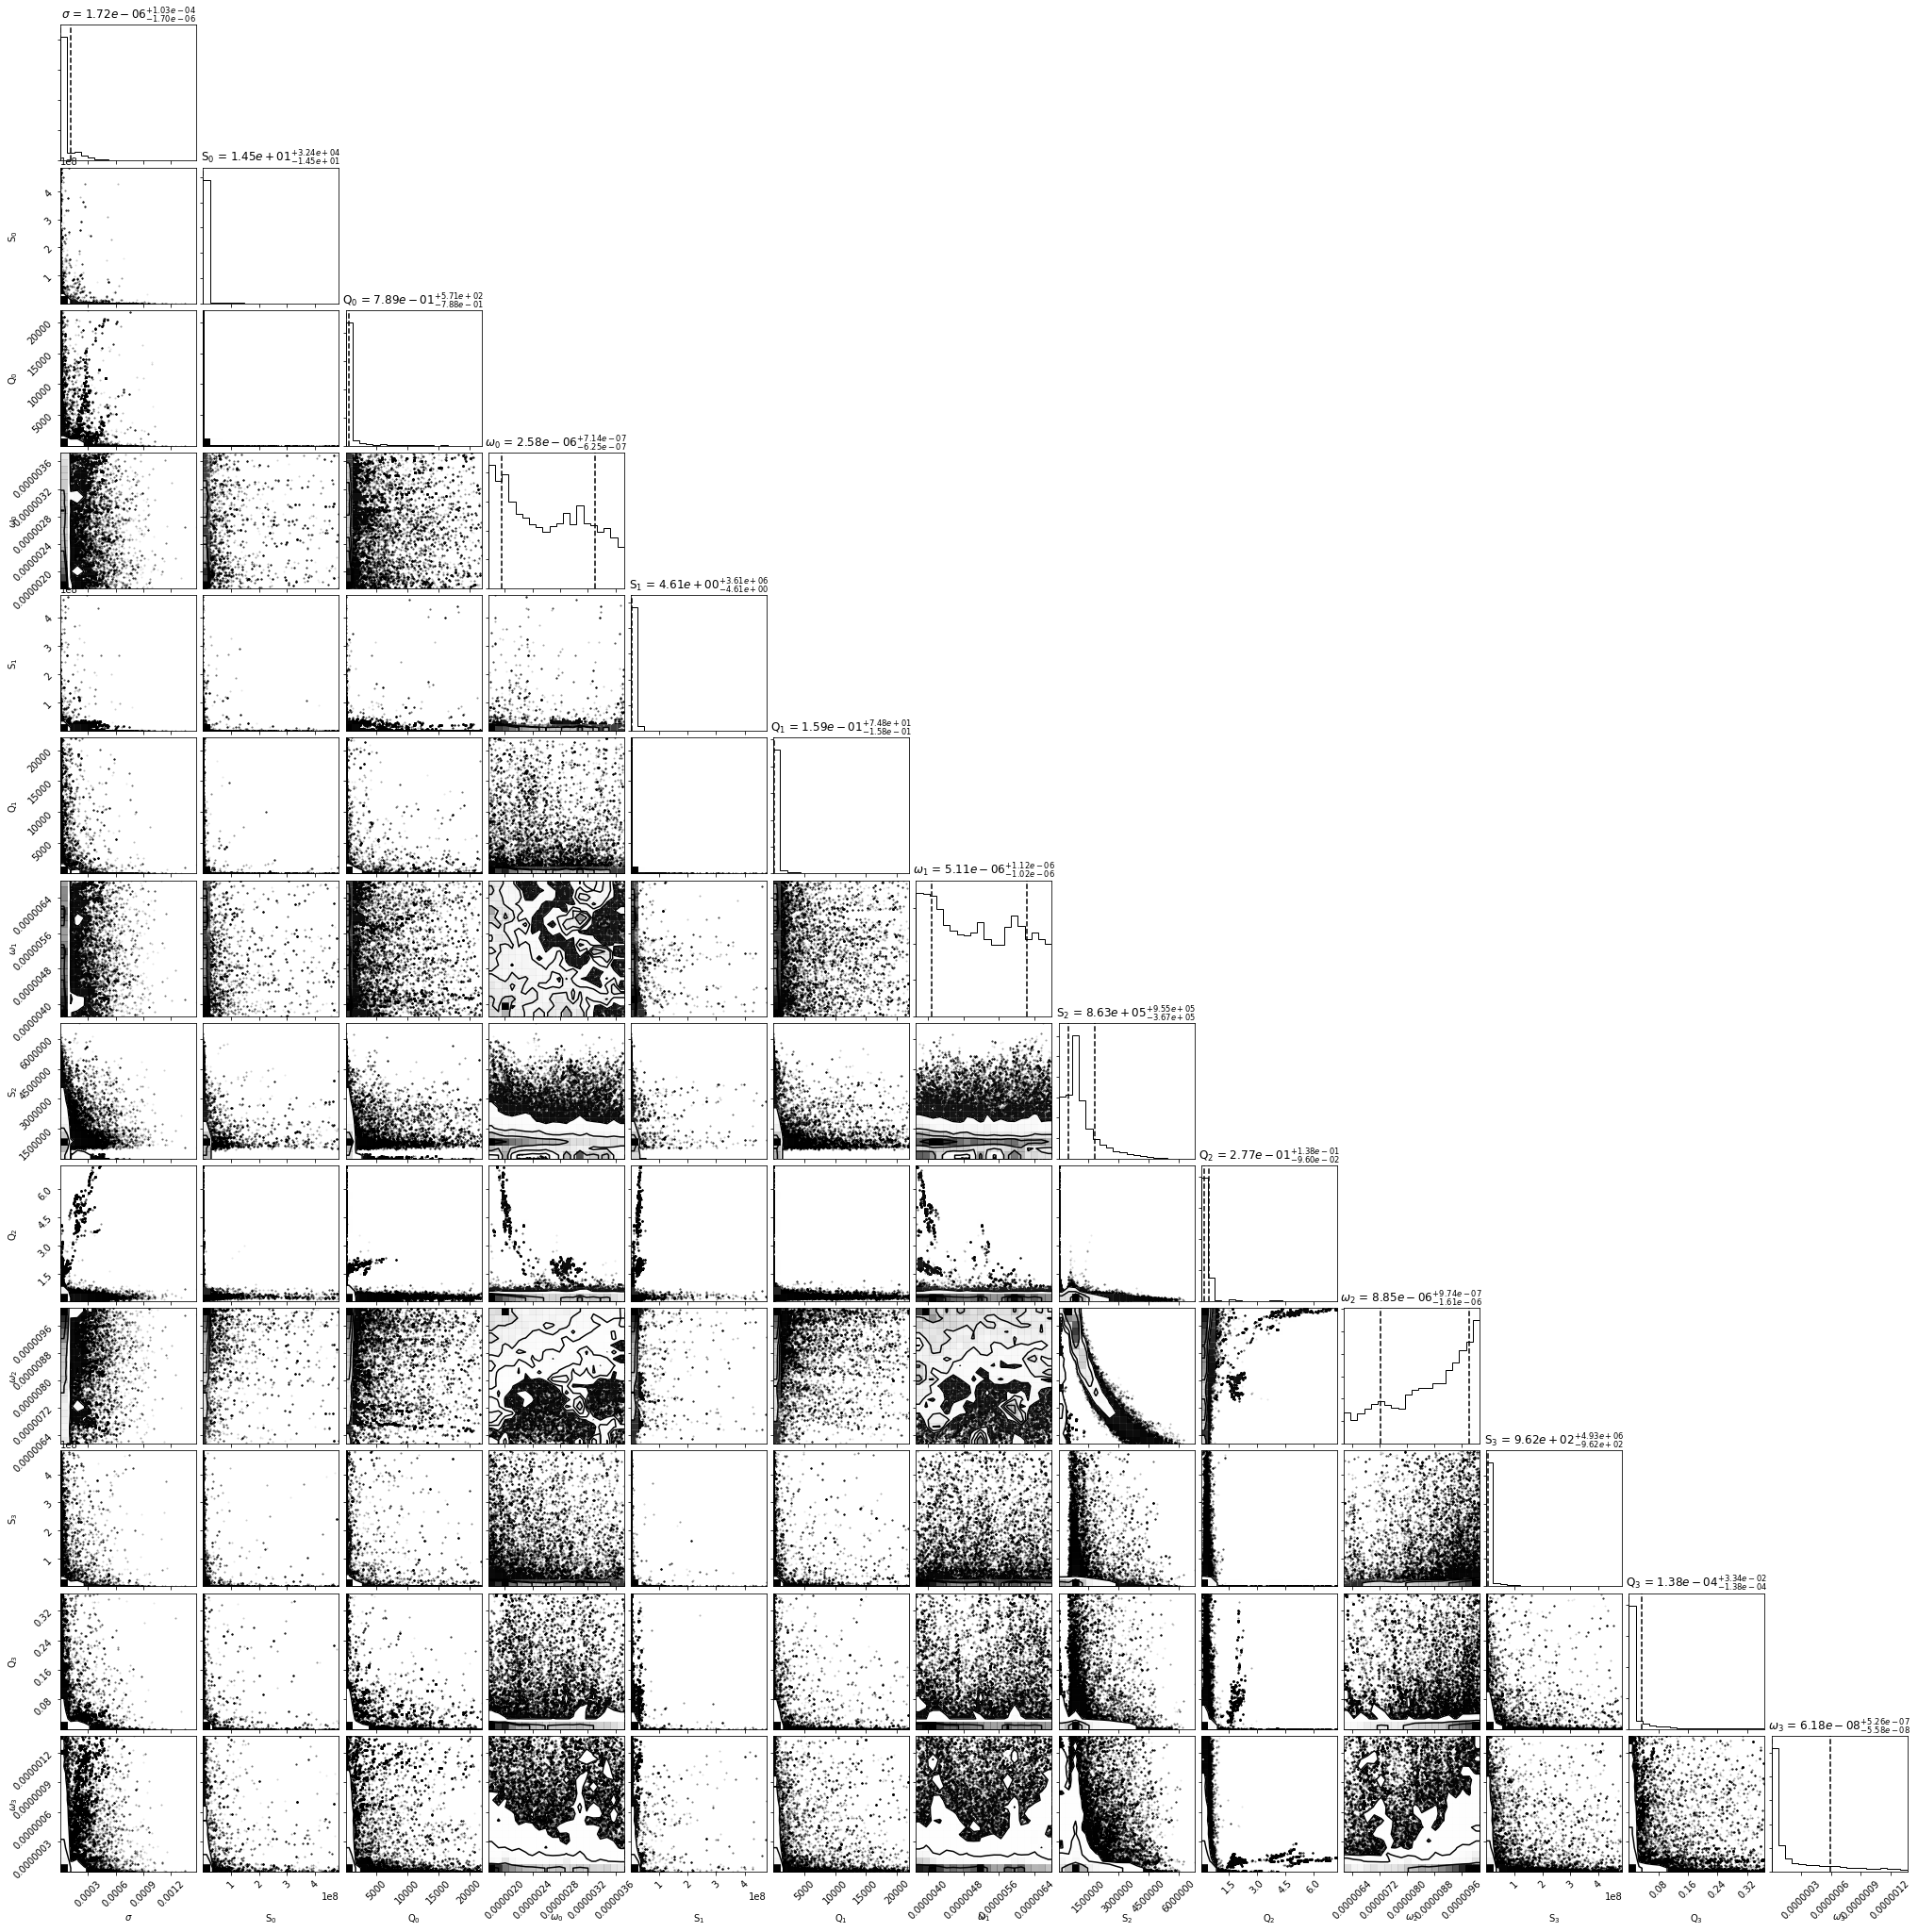

[1.35245824e-04 1.07530896e-01 3.06864000e+03 3.63708998e-06
 2.31357934e+10 9.90587199e-04 3.91203372e-06 1.18474061e+02
 4.19441422e-02 6.02887389e-06 2.34362051e+01 8.53180320e-02
 3.41738828e-07]


In [11]:
import corner

fit = np.percentile(exp_sam, 50, axis=0)
lower_std = abs(np.percentile(exp_sam, 50-34.13, axis=0) - fit)
upper_std = abs(np.percentile(exp_sam, 50+34.13, axis=0) - fit)

print("%s= %.5e (+%.5e / -%.5e)"%(lbls[0], fit[0], upper_std[0], lower_std[0]))
print("%s= %.5e (+%.5e / -%.5e)"%(lbls[1], fit[1], upper_std[1], lower_std[1]))
print("%s= %.5e (+%.5e / -%.5e)"%(lbls[2], fit[2], upper_std[2], lower_std[2]))
print("%s= %.5e (+%.5e / -%.5e)"%(lbls[3], fit[3], upper_std[3], lower_std[3]))
#print("%s= %.5e (+%.5e / -%.5e)"%(lbls[4], fit[4], upper_std[4], lower_std[4]))

"""prd = (1/(fit[3]/(2*np.pi)))/(24*3600)
prd_low = upper_std[3] * prd / fit[3] # use upp omega to get lower period (as inverse)
prd_upp = lower_std[3] * prd / fit[3] # use low omega to get upper period (as inverse)
print("Period: %.3f days (+%.3f / -%.3f) days"%(prd, prd_upp, prd_low))
"""

corner.corner(exp_sam,
                show_titles = True,
                labels = lbls,
                quantiles = [0.5-0.3413, 0.5+0.3413], 
                title_fmt='.2e')
plt.savefig('GP_test_corner.png', dpi=300)
plt.show()

print(np.exp(gp.get_parameter_vector()))
#print("Period: %.6e"%model.P)
#print("Amplitude: %.6e"%model.A)

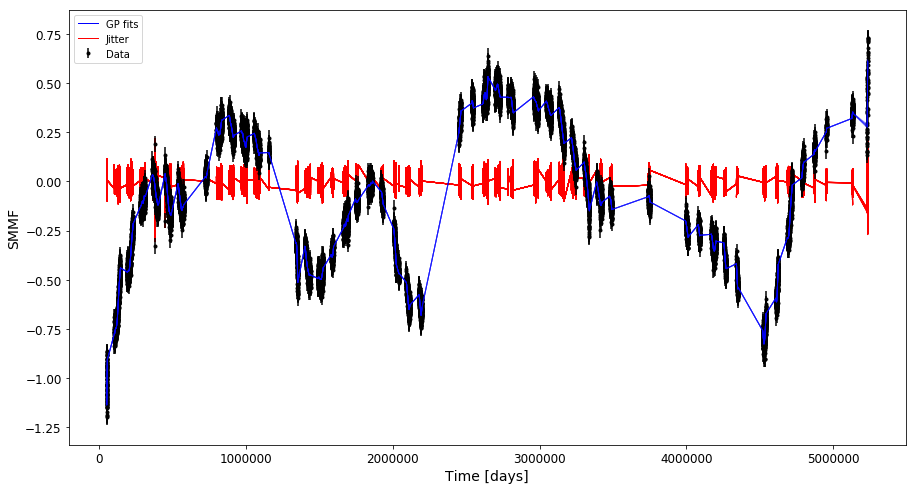

In [12]:
# Plot the data.
fig, ax = plt.subplots(figsize=(15,8))
ax.set_xlabel('Time [s]', fontsize=14)
ax.set_ylabel('SMMF', fontsize=14)
ax.tick_params(labelsize=12)

ax.errorbar(good_SMMF.t.values, good_SMMF['SMMF'].values, yerr=good_SMMF['err'], fmt=".k", capsize=0, label='Data', zorder=2)

#lp = like(t, df['SMMF'].values, yerr)
# Plot GP samples.
#samples = sampler.flatchain
itn = 0
for s in sam[np.random.randint(len(sam), size=53)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(good_SMMF['SMMF'].values, good_SMMF['t'], return_cov=False)
    if itn == 0:
        a = ax.plot(good_SMMF.t.values, mu, color='b', alpha=1, lw=1.0, label='GP fits', zorder=3)
        b = ax.plot(good_SMMF.t.values, good_SMMF['SMMF'].values - mu, color='r', alpha=1, lw=1.0, label='Jitter', zorder=1)
        itn+=1
    else:
        a = ax.plot(good_SMMF.t.values, mu, color='b', alpha=0.1, lw=1.0, zorder=3)
        b = ax.plot(good_SMMF.t.values, good_SMMF['SMMF'].values - mu, color='r', alpha=1, lw=1.0, zorder=1)

ax.legend()

No. kernel terms: 5


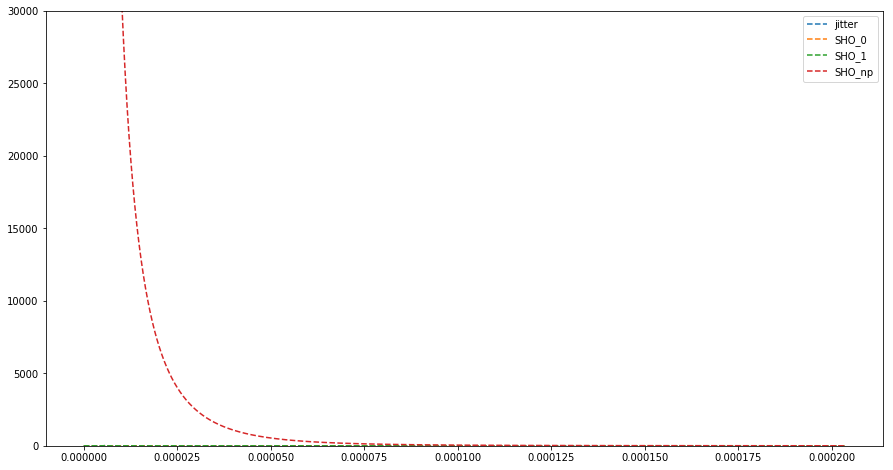

In [13]:
omega = np.exp(np.linspace(-21, -8.5, 5000))
psd = gp.kernel.get_psd(omega)
fig, ax = plt.subplots(figsize=(15,8))
print('No. kernel terms: %s'%len(gp.kernel.terms))
ls = ['jitter', 'SHO_0', 'SHO_1', 'SHO_np']
for k, l in zip(gp.kernel.terms, ls):
    ax.plot(omega, k.get_psd(omega), "--", label=l)
ax.set_ylim(0, 3e4)
plt.legend()

In [ ]:
x = np.arange(0, good_SMMF.t.values[-1], 400)
print(len(x))
pred_mean, pred_var = gp.predict(good_SMMF['SMMF'].values, x, return_var=True)

13088
